In [1]:
#importing libraries
from importlib import reload

import os
import sys
sys.path.insert(1, '../python/')

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import sklearn.ensemble
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_validate

from which_trials import which_trials

In [25]:
#specify folder and session of the experiment
folder = 'JawsM15' #ChrM04 or JawsM15 or C57_2_DualTask
session = '20200609' #20200521-6 or 20200605-09 or 20200116-20

In [26]:
#this is the fluorescence data
data = loadmat('../DataForAlexandre/' + folder + '/' + session + 'SumFluoTraceFile' + '.mat')

In [27]:
X_fluo = np.rollaxis(data['C_df'],1,0)
X_fluo_df = np.rollaxis(data['dFF0'],1,0)
X_rates = np.rollaxis(data['S_dec'],1,0)
y_labels = data['Events'].transpose()

In [28]:
print('data.shape')
print('#trials, #neuron, #frames (time)')
print(X_fluo.shape)
print(X_fluo_df.shape)
print(X_rates.shape)

print('labels.shape')
print('#labels, #trials')
print(y_labels.shape)
print(y_labels[4])

data.shape
#trials, #neuron, #frames (time)
(192, 1423, 121)
(192, 1423, 121)
(192, 1423, 121)
labels.shape
#labels, #trials
(9, 192)
[14 13  0  0 14 14  0 14 13  0 13 13  0 14  0 13 14 13  0 13 13 14 14  0
 13  0 13 14  0 13 13  0 13 14  0 13  0  0 13  0 14 14 14  0 14 14 14 13
  0 13 14 14  0 13 14  0 13 13 14  0  0 13  0  0  0 13 14 14 14 14 13 13
  0 14 13 14 14 14  0 13 13 13  0 13  0 14 13 13  0 14 13 14  0  0  0 14
  0 13 14 14  0 13 14 13  0 14 13 14 14 14 13  0  0  0 14 13 13  0  0 13
 14 13  0  0 14 14 14 14  0  0 13  0 13 14 13 14  0 13 13  0 13 14 13  0
 14 13 14 14 14 14 13 14  0  0 13  0 13  0 13  0 13  0 13 14 14  0  0 13
 14 14  0 13 14 13 13 13  0  0 13 13 14 14 13  0 13  0 14 14  0 14  0  0]


In [29]:
print('data has nan?')
print(np.isnan(X_fluo).any())
print(np.isnan(X_fluo_df).any())
print(np.isnan(X_rates).any())
print('labels has nan?')
print(np.isnan(y_labels).any())

data has nan?
False


False
False
labels has nan?
False


In [30]:
y_ND_trials = which_trials(y_labels, 'ND_trials')
print(y_ND_trials.shape)
print(y_ND_trials)

(32,)
[  2   6  18  23  25  36  37  39  48  52  55  63  78  84  93  94  96 104
 111 112 122 123 129 136 152 153 159 161 177 183 185 191]


In [31]:
y_S1_ND_trials = which_trials(y_labels, 'S1_ND_trials')
print(y_S1_ND_trials.shape)
print(y_S1_ND_trials)
y_S2_ND_trials = which_trials(y_labels, 'S2_ND_trials')
print(y_S2_ND_trials.shape)
print(y_S2_ND_trials)

(16,)
[  6  18  25  36  48  63  78  93  96 104 129 136 152 161 185 191]
(16,)
[  2  23  37  39  52  55  84  94 111 112 122 123 153 159 177 183]


In [32]:
X_S1_ND_trials = X_rates[y_S1_ND_trials]
print(X_S1_ND_trials.shape)
X_S2_ND_trials = X_rates[y_S2_ND_trials]
print(X_S2_ND_trials.shape)

(16, 1423, 121)
(16, 1423, 121)


In [33]:
def binArray(data, axis, binstep, binsize):
    out = [np.mean(np.take(data,np.arange(int(i*binstep),int(i*binstep+binsize)), axis=2), axis=2) for i in np.arange(data.shape[2]//binstep)-1]
    out = np.array(out)
    out = np.rollaxis(out,0,3)
    return out

In [34]:
X_S1_ND_trials = binArray(X_S1_ND_trials,2,1.5,3)
print(X_S1_ND_trials.shape)
X_S2_ND_trials = binArray(X_S2_ND_trials,2,1.5,3)
print(X_S2_ND_trials.shape)

(16, 1423, 80)


(16, 1423, 80)


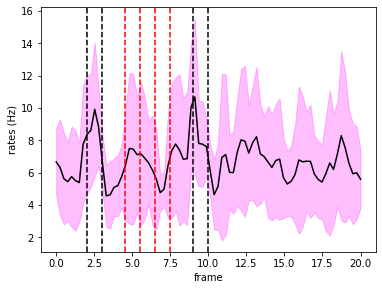

In [35]:
time = np.linspace(0,20,X_S2_ND_trials.shape[2]);
X_window = np.mean(X_S2_ND_trials, axis=1) # avg over neurons 
X_avg = np.mean(X_window,axis=0)*1000 # avg over trials 
X_std = np.std(X_window,axis=0)*1000 # std over trials

plt.plot(time,X_avg,c='k')
plt.fill_between(time, X_avg - X_std, X_avg + X_std, alpha=0.25, color='magenta')

plt.axvline(x=2, c='k', ls='--') # DPA sample onset 
plt.axvline(x=3, c='k', ls='--')

plt.axvline(x=9, c='k', ls='--') # DPA test onset
plt.axvline(x=10, c='k', ls='--')

plt.axvline(x=4.5, c='r', ls='--') # DRT distractor onset
plt.axvline(x=5.5, c='r', ls='--')

plt.axvline(x=6.5, c='r', ls='--') # DRT cue onset
plt.axvline(x=7.5, c='r', ls='--')

plt.xlabel('frame') ;
plt.ylabel('rates (Hz)') ;

In [36]:
#generating the labels from the length of the trials (samples)
y_S1 = np.repeat(0,int(X_S1_ND_trials.shape[0]))
print(np.unique(y_S1, return_counts=True))

y_S2 = np.repeat(1,int(X_S1_ND_trials.shape[0]))
print(np.unique(y_S2, return_counts=True))

y_S1_S2 = np.concatenate((y_S1, y_S2))
print(y_S1_S2)

(array([0]), array([16]))
(array([1]), array([16]))
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [37]:
#concatenating S1 and S2 by the trials
X_S1_S2 = np.concatenate((X_S1_ND_trials, X_S2_ND_trials), axis=0)
print(X_S1_S2.shape)

(32, 1423, 80)


In [61]:
time_window = 3
split_windows = np.array_split(X_S1_S2, X_S1_S2.shape[2]/time_window, axis=2)

In [62]:
#defining the time vector
time = np.linspace(0, X_rates.shape[2]/6, num=len(split_windows))
print(time)

[ 0.          0.80666667  1.61333333  2.42        3.22666667  4.03333333
  4.84        5.64666667  6.45333333  7.26        8.06666667  8.87333333
  9.68       10.48666667 11.29333333 12.1        12.90666667 13.71333333
 14.52       15.32666667 16.13333333 16.94       17.74666667 18.55333333
 19.36       20.16666667]


In [63]:
from decode_utils import *

In [64]:
cv = 5
model_name = 'svm_linear'
scoring = {'f_score S1': make_scorer(f1_score, average = None, labels = [0]),
       'f_score S2': make_scorer(f1_score, average = None, labels = [1])}
clf = svm.LinearSVC() #svm.SVC(kernel='rbf', random_state=1, gamma=.001, C=1)

In [65]:
S1_f_score, S2_f_score, S1_f_score_std, S2_f_score_std = cross_validate_clf(split_windows, y_S1_S2, cv, scoring, clf) ;

Window iteration #1
window shape of current iteration
(32, 1423, 4)
crossvalidation  value #1
fit_time
[0.01511264 0.01822138 0.02188349 0.02025437 0.0137465 ]
crossvalidation  value #2
score_time
[0.00374985 0.00370479 0.00351548 0.00356412 0.00322104]
crossvalidation  value #3
test_f_score S1
[0.44444444 0.         0.8        0.33333333 0.28571429]
crossvalidation  value #4
test_f_score S2
[0.         0.72727273 0.85714286 0.33333333 0.        ]
Window iteration #2
window shape of current iteration
(32, 1423, 4)


crossvalidation  value #1
fit_time
[0.01953912 0.01947474 0.02356625 0.02239943 0.02005482]
crossvalidation  value #2
score_time
[0.00334692 0.00373411 0.00392127 0.00372505 0.00376725]
crossvalidation  value #3
test_f_score S1
[0.66666667 0.4        0.33333333 0.4        0.4       ]
crossvalidation  value #4
test_f_score S2
[0.4        0.66666667 0.33333333 0.57142857 0.57142857]
Window iteration #3
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01451564 0.00988483 0.01470184 0.01766467 0.0179193 ]
crossvalidation  value #2
score_time
[0.0035944  0.00335217 0.00381732 0.00370193 0.00370383]
crossvalidation  value #3
test_f_score S1
[0.88888889 1.         1.         0.4        0.66666667]
crossvalidation  value #4
test_f_score S2
[0.8        1.         1.         0.57142857 0.66666667]
Window iteration #4
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.00972247 0.01527953 0.01466012 0.01618814 0.01700044]
crossvalidation  value #2
score_time
[0.00381804 0.00374818 0.0037117  0.00401354 0.00380254]
crossvalidation  value #3
test_f_score S1
[0.66666667 0.5        1.         1.         0.66666667]
crossvalidation  value #4
test_f_score S2
[0.4        0.8        1.         1.         0.66666667]
Window iteration #5
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.00985932 0.01587844 0.01174974 0.01585889 0.01446867]
crossvalidation  value #2
score_time
[0.00360036 0.00330305 0.00383329 0.00375104 0.00368524]
crossvalidation  value #3
test_f_score S1
[0.5        0.5        1.         0.85714286 1.        ]
crossvalidation  value #4
test_f_score S2
[0.33333333 0.8        1.         0.8        1.        ]
Window iteration #6
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01396489 0.01397514 0.01829886 0.01586485 0.01628232]
crossvalidation  value #2
score_time
[0.00342798 0.00383759 0.00366259 0.00354123 0.00368214]
crossvalidation  value #3
test_f_score S1
[0.8        0.5        0.8        0.66666667 0.85714286]
crossvalidation  value #4
test_f_score S2
[0.5        0.8        0.85714286 0.66666667 0.8       ]
Window iteration #7
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01301503 0.01270819 0.01624751 0.01876116 0.0176034 ]
crossvalidation  value #2
score_time
[0.00376129 0.00389743 0.00367999 0.00352693 0.00375366]
crossvalidation  value #3
test_f_score S1
[0.6        0.5        0.66666667 0.66666667 0.8       ]
crossvalidation  value #4
test_f_score S2
[0.         0.8        0.66666667 0.66666667 0.85714286]
Window iteration #8
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01377106 0.01344562 0.01715088 0.01401067 0.01711249]
crossvalidation  value #2
score_time
[0.00371432 0.00363421 0.00362396 0.00372529 0.00368071]
crossvalidation  value #3
test_f_score S1
[0.66666667 0.         0.8        0.4        0.66666667]
crossvalidation  value #4
test_f_score S2
[0.4        0.72727273 0.85714286 0.57142857 0.66666667]
Window iteration #9
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01514292 0.0144372  0.01740003 0.0139761  0.01494622]
crossvalidation  value #2
score_time
[0.00368595 0.00414467 0.00360537 0.00371766 0.0035975 ]
crossvalidation  value #3
test_f_score S1
[0.6        0.4        0.57142857 0.57142857 0.8       ]
crossvalidation  value #4
test_f_score S2
[0.         0.66666667 0.4        0.4        0.85714286]
Window iteration #10
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01648259 0.01533747 0.01570892 0.01237893 0.01731873]
crossvalidation  value #2
score_time
[0.003582   0.00357437 0.00367618 0.00331903 0.00327849]
crossvalidation  value #3
test_f_score S1
[0.66666667 0.33333333 0.66666667 0.66666667 0.4       ]
crossvalidation  value #4
test_f_score S2
[0.4        0.5        0.66666667 0.66666667 0.57142857]
Window iteration #11
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.0093894  0.01657057 0.00994611 0.01678538 0.01690125]
crossvalidation  value #2
score_time
[0.00392389 0.00385022 0.00373316 0.00381684 0.00376987]
crossvalidation  value #3
test_f_score S1
[0.8        0.4        0.4        0.4        0.66666667]
crossvalidation  value #4
test_f_score S2
[0.5        0.66666667 0.57142857 0.57142857 0.66666667]
Window iteration #12
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01422691 0.01475382 0.01265788 0.01700997 0.01887655]
crossvalidation  value #2
score_time
[0.0039537  0.0035491  0.00370908 0.0035398  0.00387645]
crossvalidation  value #3
test_f_score S1
[0.6        0.33333333 0.4        0.66666667 0.66666667]
crossvalidation  value #4
test_f_score S2
[0.         0.5        0.57142857 0.66666667 0.66666667]
Window iteration #13
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01436377 0.01471162 0.015836   0.01153064 0.01549459]
crossvalidation  value #2
score_time
[0.00392222 0.00370455 0.00373363 0.00421429 0.00380135]
crossvalidation  value #3
test_f_score S1
[0.72727273 0.         0.8        1.         0.8       ]
crossvalidation  value #4
test_f_score S2
[0.         0.6        0.85714286 1.         0.85714286]
Window iteration #14
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01218581 0.01310682 0.0183363  0.01707315 0.02507567]
crossvalidation  value #2
score_time
[0.00383592 0.00363088 0.00377011 0.00378776 0.00410295]
crossvalidation  value #3
test_f_score S1
[0.75       0.4        0.33333333 1.         0.8       ]
crossvalidation  value #4
test_f_score S2
[0.66666667 0.66666667 0.33333333 1.         0.85714286]
Window iteration #15
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01713514 0.01328874 0.01354599 0.02001667 0.01767373]
crossvalidation  value #2
score_time
[0.00364709 0.00349426 0.00381327 0.00366688 0.00398874]
crossvalidation  value #3
test_f_score S1
[0.6        0.5        0.         0.57142857 0.4       ]
crossvalidation  value #4
test_f_score S2
[0.         0.8        0.28571429 0.4        0.57142857]
Window iteration #16
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01480508 0.01589417 0.01514602 0.01336145 0.018291  ]
crossvalidation  value #2
score_time
[0.00380015 0.00341916 0.00369763 0.00354934 0.00369668]
crossvalidation  value #3
test_f_score S1
[0.72727273 0.         0.33333333 0.33333333 0.28571429]
crossvalidation  value #4
test_f_score S2
[0.         0.72727273 0.33333333 0.33333333 0.        ]
Window iteration #17
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01554489 0.01376414 0.01654744 0.01724267 0.02174211]
crossvalidation  value #2
score_time
[0.00359249 0.00345945 0.00389671 0.00366807 0.00367689]
crossvalidation  value #3
test_f_score S1
[0.6        0.         0.33333333 0.66666667 0.28571429]
crossvalidation  value #4
test_f_score S2
[0.         0.6        0.33333333 0.66666667 0.        ]
Window iteration #18
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01527309 0.01665831 0.0168395  0.0156641  0.01463246]
crossvalidation  value #2
score_time
[0.00381756 0.00391173 0.00362396 0.00360084 0.00374436]
crossvalidation  value #3
test_f_score S1
[0.6        0.         0.66666667 0.57142857 0.33333333]
crossvalidation  value #4
test_f_score S2
[0.         0.72727273 0.66666667 0.4        0.33333333]
Window iteration #19
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01593375 0.01653147 0.01635718 0.0179143  0.01612401]
crossvalidation  value #2
score_time
[0.0036099  0.00367498 0.00359297 0.0036087  0.00371313]
crossvalidation  value #3
test_f_score S1
[0.72727273 0.5        0.85714286 0.66666667 0.4       ]
crossvalidation  value #4
test_f_score S2
[0.         0.8        0.8        0.66666667 0.57142857]
Window iteration #20
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01302338 0.01354408 0.01339126 0.01695442 0.02106071]
crossvalidation  value #2
score_time
[0.0036912  0.00359941 0.00375247 0.00355959 0.00376725]
crossvalidation  value #3
test_f_score S1
[0.6        0.5        0.         0.5        0.66666667]
crossvalidation  value #4
test_f_score S2
[0.         0.8        0.         0.75       0.66666667]
Window iteration #21
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01532435 0.01239872 0.01709771 0.01692915 0.02030277]
crossvalidation  value #2
score_time
[0.0036006  0.00374007 0.00355387 0.00359035 0.00370431]
crossvalidation  value #3
test_f_score S1
[0.72727273 0.66666667 0.33333333 0.66666667 0.33333333]
crossvalidation  value #4
test_f_score S2
[0.         0.75       0.33333333 0.66666667 0.33333333]
Window iteration #22
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01417756 0.01493287 0.0148797  0.01449156 0.01179695]
crossvalidation  value #2
score_time
[0.00371528 0.00380564 0.00392485 0.00380635 0.00382972]
crossvalidation  value #3
test_f_score S1
[0.6        0.33333333 0.28571429 0.33333333 0.33333333]
crossvalidation  value #4
test_f_score S2
[0.         0.5        0.         0.33333333 0.33333333]
Window iteration #23
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01728773 0.01452374 0.01435184 0.01425076 0.01782465]
crossvalidation  value #2
score_time
[0.00371003 0.00365353 0.00355673 0.00375485 0.00382304]
crossvalidation  value #3
test_f_score S1
[0.44444444 0.4        0.33333333 0.8        0.66666667]
crossvalidation  value #4
test_f_score S2
[0.         0.66666667 0.33333333 0.85714286 0.66666667]
Window iteration #24
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01357746 0.01533508 0.01848221 0.01690364 0.01836658]
crossvalidation  value #2
score_time
[0.00368309 0.00359368 0.0042119  0.00364685 0.00368214]
crossvalidation  value #3
test_f_score S1
[0.6 0.  0.  0.  0. ]
crossvalidation  value #4
test_f_score S2
[0.         0.72727273 0.5        0.         0.28571429]
Window iteration #25
window shape of current iteration
(32, 1423, 3)
crossvalidation  value #1
fit_time
[0.01565599 0.01432157 0.01793408 0.01528072 0.01677775]
crossvalidation  value #2
score_time
[0.00383186 0.00376749 0.00349331 0.00368738 0.0036211 ]
crossvalidation  value #3
test_f_score S1
[0.6        0.         0.28571429 0.28571429 0.        ]
crossvalidation  value #4
test_f_score S2
[0.  0.6 0.  0.  0.5]
Window iteration #26
window shape of current iteration
(32, 1423, 3)


crossvalidation  value #1
fit_time
[0.01614404 0.01492786 0.01576138 0.01674652 0.01109552]
crossvalidation  value #2
score_time
[0.00389433 0.00349045 0.00365138 0.00378728 0.00402808]
crossvalidation  value #3
test_f_score S1
[0.72727273 0.         0.57142857 1.         0.57142857]
crossvalidation  value #4
test_f_score S2
[0.  0.6 0.4 1.  0.4]


In [66]:
#sample of the results
print('S1_f_score')
print(S1_f_score)
print('\nList lenght (f_score) ' + str(len(S1_f_score)))

S1_f_score
[0.37269841 0.44       0.79111111 0.76666667 0.77142857 0.7247619
 0.64666667 0.50666667 0.58857143 0.54666667 0.53333333 0.53333333
 0.66545455 0.65666667 0.41428571 0.33593074 0.37714286 0.43428571
 0.63021645 0.45333333 0.54545455 0.37714286 0.52888889 0.12
 0.23428571 0.57402597]

List lenght (f_score) 26


In [67]:
#sample of the results
print('S2_f_score')
print(S2_f_score)
print('\nList lenght (f_score) ' + str(len(S2_f_score)))

S2_f_score
[0.38354978 0.50857143 0.80761905 0.77333333 0.78666667 0.7247619
 0.59809524 0.64450216 0.4647619  0.56095238 0.5952381  0.48095238
 0.66285714 0.7047619  0.41142857 0.27878788 0.32       0.42545455
 0.56761905 0.44333333 0.41666667 0.23333333 0.5047619  0.3025974
 0.22       0.48      ]

List lenght (f_score) 26


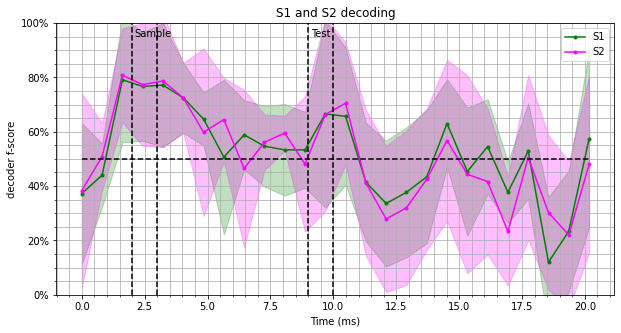

In [68]:
plot_decoding_results(S1_f_score, S2_f_score, S1_f_score_std, S2_f_score_std, time)